In [1]:
# Import OpenMC library for simulation
import openmc

# Import NumPy for numerical operations
import numpy as np

# Import matplotlib for plotting (optional)
import matplotlib.pyplot as plt

import h5py

# Conversion factors
inch_to_cm = 2.54  # 1 inch = 2.54 cm


In [2]:
########################   Materials #######################################

# Create a Materials collection
materials = openmc.Materials()

In [3]:
# 1. Deuterium Gas
# ----------------
# Deuterium gas at low pressure due to high vacuum
# We'll assume a low density for the deuterium gas

# 1. Deuterium Gas
deuterium = openmc.Material(name='Deuterium Gas')
deuterium.add_nuclide('H2', 1.0, percent_type='ao')
deuterium.set_density('g/cm3', 1e-6)
materials.append(deuterium)

In [4]:
# 2. 504 Stainless Steel
# ----------------------
# Composition based on typical 504 stainless steel

# Stainless Steel (approximate composition for 504 stainless steel)
steel = openmc.Material(name='Stainless Steel')
steel.add_element('Fe', 0.70)
steel.add_element('Cr', 0.18)
steel.add_element('Ni', 0.12)
steel.set_density('g/cm3', 8.0)
materials.append(steel)

In [5]:
# 3. Tungsten
# -----------
# Used for the inner grid

tungsten = openmc.Material(name='Tungsten')
tungsten.add_element('W', 1.0)
tungsten.set_density('g/cm3', 19.25)
materials.append(tungsten)

In [6]:
# 4.A Inner Grid Material (Volume-Averaged)
#----------------------------------------

# Calculations:
# Wire parameters
number_of_wires = 3
wire_diameter = 0.25  # cm (assumed value)
wire_radius = wire_diameter / 2

# Inner grid diameter and radius
inner_diameter_in = 2.0  # inches
inner_diameter_cm = inner_diameter_in * inch_to_cm
inner_radius_cm = inner_diameter_cm / 2

# Length of each wire (circumference of circle)
wire_length = np.pi * inner_diameter_cm  # cm

# Cross-sectional area of the wire
cross_sectional_area = np.pi * wire_radius**2  # cm^2

# Volume of one wire
volume_wire = wire_length * cross_sectional_area  # cm^3

# Total volume of wires
volume_wires = number_of_wires * volume_wire  # cm^3

# Volume of inner grid shell (approximate as thin shell)
delta_r = wire_diameter  # cm (thickness of inner grid shell)
volume_inner_grid_shell = 4 * np.pi * inner_radius_cm**2 * delta_r  # cm^3

# Volume fraction of tungsten in the inner grid shell
volume_fraction_W = volume_wires / volume_inner_grid_shell

print(f"Volume of wires: {volume_wires:.5e} cm^3")
print(f"Volume of inner grid shell: {volume_inner_grid_shell:.5e} cm^3")
print(f"Volume fraction of tungsten: {volume_fraction_W:.5e}")

Volume of wires: 2.35020e+00 cm^3
Volume of inner grid shell: 2.02683e+01 cm^3
Volume fraction of tungsten: 1.15954e-01


In [7]:
# 4.B Add the inner grid average material to xml
#----------------------------------------------

# Compute the density of the inner grid material
density_W = 19.25  # g/cm3 for tungsten
density_deuterium = deuterium.density  # Should be 1e-10 g/cm3

# Compute density of inner grid material (negligible contribution from deuterium)
density_inner_grid_material = volume_fraction_W * density_W

# Create a new material for the inner grid region
inner_grid_material = openmc.Material(name='Inner Grid Material')
inner_grid_material.add_element('W', 1.0)
inner_grid_material.set_density('g/cm3', density_inner_grid_material)
materials.append(inner_grid_material)


In [8]:
# 5. Material for Air
# --------------------

# Create material for air
air = openmc.Material(name='Air')
air.add_element('N', 0.78084)
air.add_element('O', 0.20946)
air.add_element('Ar', 0.00934)
air.add_element('C', 0.00036)
air.set_density('g/cm3', 0.0012)  # Density of air at sea level in g/cm3

# Add the air material to the materials collection
materials.append(air)


In [9]:
#6. Material for Tritium Blanket
# --------------------

# Create material for lithium
lithium = openmc.Material(name='Lithium')
lithium.add_nuclide('Li6', 0.075)  # Natural abundance
lithium.add_nuclide('Li7', 0.925)
lithium.set_density('g/cm3', 0.534)

materials.append(lithium)

In [10]:
#5. Export materials to XML
#---------------------

materials.export_to_xml()

In [11]:
# 1. Outer Shell and Blanket
# --------------
# Diameter: 8 inches
outer_diameter_in = 8.0
outer_diameter_cm = outer_diameter_in * inch_to_cm  # Convert to cm
outer_radius_cm = outer_diameter_cm / 2

# Thickness: 1/8 inch
shell_thickness_in = 0.125
shell_thickness_cm = shell_thickness_in * inch_to_cm

# Inner radius of the outer shell
outer_shell_inner_radius = outer_radius_cm - shell_thickness_cm

# Outer surface of the outer shell (boundary of the geometry)
outer_shell_outer_surface = openmc.Sphere(r=outer_radius_cm)

# Inner surface of the outer shell
outer_shell_inner_surface = openmc.Sphere(r=outer_shell_inner_radius)

# Thickness of the lithium blanket
blanket_thickness = 5.0

# Radius of the lithium blanket
blanket_outer_radius = outer_radius_cm + blanket_thickness

# Outer surface of lithium blanket
blanket_outer_surface = openmc.Sphere(r=blanket_outer_radius)

# Define an outer boundary
outer_boundary_radius = outer_radius_cm + 50
outer_boundary_surface = openmc.Sphere(r=outer_boundary_radius, boundary_type='vacuum')

In [12]:
# 2. Inner Grid
# -------------
# Inner grid radius is inner_radius_cm (already defined)

# Small thickness for the inner grid shell
delta_r = 0.001  # cm

# Inner and outer surfaces of the inner grid shell
inner_grid_shell_inner_surface = openmc.Sphere(r=inner_radius_cm - delta_r/2)
inner_grid_shell_outer_surface = openmc.Sphere(r=inner_radius_cm + delta_r/2)

In [13]:
# 3. Regions
# ----------
# Core region (inside inner grid shell)
core_region = -inner_grid_shell_inner_surface

# Inner grid shell region
inner_grid_shell_region = +inner_grid_shell_inner_surface & -inner_grid_shell_outer_surface

# Gas region (between inner grid shell and outer shell inner surface)
gas_region = +inner_grid_shell_outer_surface & -outer_shell_inner_surface

# Outer shell region
outer_shell_region = +outer_shell_inner_surface & -outer_shell_outer_surface

# Blanket region
blanket_region = +outer_shell_outer_surface & -blanket_outer_surface

# Final outer region
outermost_region = +blanket_outer_surface & -outer_boundary_surface

In [14]:
# 4. Cells
# --------

# Core plasma cell
core_cell = openmc.Cell(name='Core Plasma', fill=deuterium, region=core_region)

# Inner grid shell cell
inner_grid_cell = openmc.Cell(name='Inner Grid Shell', fill=inner_grid_material, region=inner_grid_shell_region)

# Gas cell
gas_cell = openmc.Cell(name='Deuterium Gas', fill=deuterium, region=gas_region)

# Outer shell cell
outer_shell_cell = openmc.Cell(name='Outer Shell', fill=steel, region=outer_shell_region)

# Blanket cell
blanket_cell = openmc.Cell(name='Lithium Blanket', fill=lithium, region=blanket_region)

# Outermost region cell
outermost_region_cell =  openmc.Cell(name='Outermost Region', fill=air, region=outermost_region)

In [15]:
# 5. Universe and Geometry
# ------------------------
universe = openmc.Universe(cells=[core_cell, inner_grid_cell, gas_cell, outer_shell_cell, blanket_cell, outermost_region_cell])
geometry = openmc.Geometry(universe)
geometry.export_to_xml()

In [16]:
# 1. Define the Neutron Source
# ----------------------------

# Neutron energy from D-D fusion (~2.45 MeV)
neutron_energy = 2.45e6  # eV

# Radial distribution: Uniform from 0 to inner radius minus half the grid thickness
radius_distribution = openmc.stats.Uniform(0.0, inner_radius_cm - delta_r/2)

# Cosine of the polar angle distribution: Uniform from -1 to 1
cos_theta_distribution = openmc.stats.Uniform(-1.0, 1.0)

# Azimuthal angle distribution: Uniform from 0 to 2*pi
phi_distribution = openmc.stats.Uniform(0.0, 2 * np.pi)

# Create the SphericalIndependent spatial distribution
source_space = openmc.stats.SphericalIndependent(
    r=radius_distribution,
    cos_theta=cos_theta_distribution,
    phi=phi_distribution
)

# Energy distribution: Monoenergetic at 2.45 MeV
source_energy = openmc.stats.Discrete([neutron_energy], [1.0])

# Angular distribution: Isotropic
source_angle = openmc.stats.Isotropic()

# Create the neutron source
source = openmc.Source(
    space=source_space,
    energy=source_energy,
    angle=source_angle,
    particle='neutron'
)

/opt/venv/lib/python3.11/site-packages/openmc/source.py:656: FutureWarning: This class is deprecated in favor of 'IndependentSource'
  warnings.warn("This class is deprecated in favor of 'IndependentSource'", FutureWarning)


In [17]:
# 1. Simulation Settings
# ----------------------

settings = openmc.Settings()
settings.run_mode = 'fixed source'  # Fixed source simulation
settings.particles = 100000          # Number of particles per batch
settings.batches = 100              # Total number of batches
settings.inactive = 0
settings.source = source            # Set the source  

settings.export_to_xml()


In [18]:
# Define the mesh over the geometry
mesh_dimension = (100, 100, 1)  # Adjust the number of bins for desired resolution
mesh_lower_left = (-outer_boundary_radius, -outer_boundary_radius, -outer_boundary_radius)
mesh_upper_right = (outer_boundary_radius, outer_boundary_radius, outer_boundary_radius)

mesh = openmc.RegularMesh()
mesh.dimension = mesh_dimension
mesh.lower_left = mesh_lower_left
mesh.upper_right = mesh_upper_right

mesh_filter = openmc.MeshFilter(mesh)

In [19]:
# Tally for tritium production reactions
tritium_tally = openmc.Tally(name='Tritium Production')
tritium_tally.filters = [mesh_filter]
tritium_tally.scores = ['(n,t)']  # Tritium production reactions
tritium_tally.nuclides = ['Li6', 'Li7']

# Create Tallies collection and export to XML
tallies = openmc.Tallies([tritium_tally])
tallies.export_to_xml()

In [20]:
# Run the simulation
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

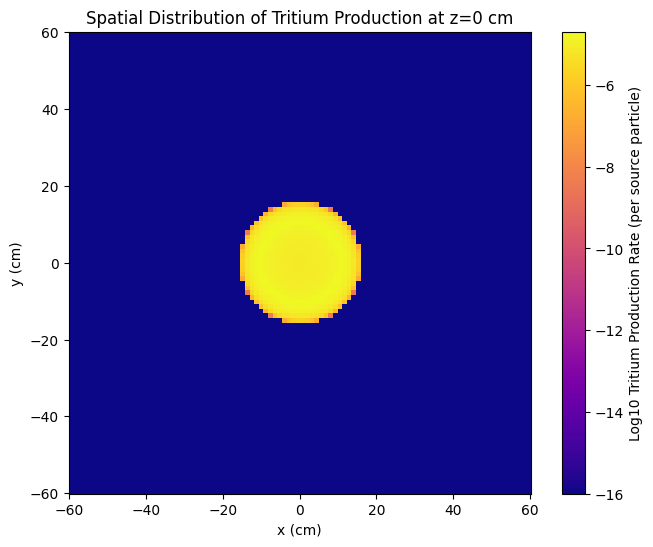

In [21]:
# Process the results
# Read the statepoint file
sp = openmc.StatePoint('statepoint.100.h5')

# Access the tritium production tally
tally_result = sp.get_tally(name='Tritium Production')

# Extract the tritium production data
tritium_data = tally_result.get_slice(scores=['(n,t)']).mean  # Shape: (num_bins, num_nuclides, num_scores)

# Remove the scores dimension (since it's size 1)
tritium_data = tritium_data.squeeze(axis=2)  # Shape: (num_bins, num_nuclides)

# Sum over nuclides to get total tritium production per mesh cell
tritium_total = tritium_data.sum(axis=1)  # Shape: (num_bins,)

# Reshape to mesh dimensions
tritium_total.shape = mesh.dimension  # Shape: (100, 100, 1)

# Since z-dimension is 1, extract the 2D array
tritium_data_2d = tritium_total[:, :, 0]

# Plot the tritium production distribution at z=0 cm
plt.figure(figsize=(8, 6))

# Use a logarithmic color scale for better detail in lower production regions
tritium_data_log = np.log10(np.maximum(tritium_data_2d, 1e-16))  # Avoid log(0)

# Adjust the colormap limits to focus on the range of interest
vmin, vmax = np.min(tritium_data_log), np.max(tritium_data_log)

plt.imshow(tritium_data_log,
           extent=[mesh_lower_left[0], mesh_upper_right[0], mesh_lower_left[1], mesh_upper_right[1]],
           origin='lower',
           cmap='plasma',
           vmin=vmin,
           vmax=vmax)

# Add color bar
cbar = plt.colorbar(label='Log10 Tritium Production Rate (per source particle)')
plt.title('Spatial Distribution of Tritium Production at z=0 cm')
plt.xlabel('x (cm)')
plt.ylabel('y (cm)')
plt.show()


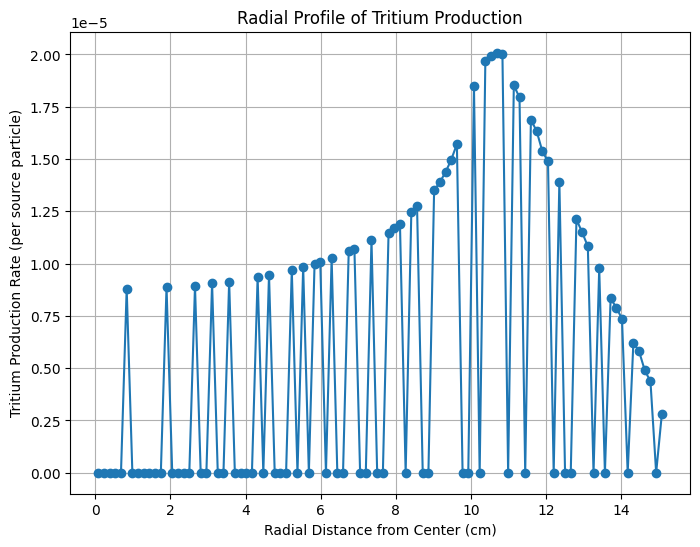

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Process the results
# Read the statepoint file
sp = openmc.StatePoint('statepoint.100.h5')

# Access the tritium production tally
tally_result = sp.get_tally(name='Tritium Production')

# Extract the tritium production data
tritium_data = tally_result.get_slice(scores=['(n,t)']).mean  # Shape: (num_bins, num_nuclides, num_scores)
tritium_data = np.squeeze(tritium_data, axis=2)  # Remove scores dimension
tritium_total = tritium_data.sum(axis=1)  # Sum over nuclides

# Reshape to mesh dimensions
tritium_total.shape = mesh.dimension  # Shape: (nx, ny, nz)

# Since z-dimension is 1, extract the 2D array
tritium_data_2d = tritium_total[:, :, 0]

# Calculate the radial distance for each mesh cell
nx, ny = mesh.dimension[0], mesh.dimension[1]
x = np.linspace(mesh.lower_left[0], mesh.upper_right[0], nx)
y = np.linspace(mesh.lower_left[1], mesh.upper_right[1], ny)
X, Y = np.meshgrid(x, y, indexing='ij')
R = np.sqrt(X**2 + Y**2)

# Flatten the arrays for binning
R_flat = R.flatten()
tritium_flat = tritium_data_2d.flatten()

# Bin the tritium production data radially
num_bins = 100
r_bins = np.linspace(0, blanket_outer_radius, num_bins+1)
bin_indices = np.digitize(R_flat, r_bins)

# Calculate the average tritium production in each radial bin
tritium_radial = np.zeros(num_bins)
for i in range(1, num_bins+1):
    mask = bin_indices == i
    if np.any(mask):
        tritium_radial[i-1] = np.mean(tritium_flat[mask])
    else:
        tritium_radial[i-1] = 0.0

# Calculate the radial positions (bin centers)
r_bin_centers = 0.5 * (r_bins[:-1] + r_bins[1:])

# Plot the radial profile
plt.figure(figsize=(8, 6))
plt.plot(r_bin_centers, tritium_radial, marker='o')
plt.title('Radial Profile of Tritium Production')
plt.xlabel('Radial Distance from Center (cm)')
plt.ylabel('Tritium Production Rate (per source particle)')
plt.grid(True)
plt.show()


In [23]:
# Calculate total tritium production
total_tritium_production = tritium_total.sum()  # Sum over all mesh cells

# Since the tally results are per source particle, you can estimate the total production rate
# if you know the source neutron rate (e.g., neutrons per second)
# For demonstration, let's assume a source rate of 1e14 neutrons per second
source_rate = 1e5  # Adjust this value based on your reactor's specifications

# Calculate the total tritium production rate (tritium atoms per second)
tritium_production_rate = total_tritium_production * source_rate

print(f"Total Tritium Production per Source Particle: {total_tritium_production:.4e}")
print(f"Total Tritium Production Rate: {tritium_production_rate:.4e} tritium atoms per second")


Total Tritium Production per Source Particle: 5.7845e-03
Total Tritium Production Rate: 5.7845e+02 tritium atoms per second
